# Week 7: Response Surface Methodology
## AIM-5014-1A: Experimental Optimization
### David Sweet // 20230713

In class we discussed the problem below. In this assignment, we will solve it.

## Song recommender

Your auto-play song recommender system determines which song to play next for a user. It works like this:

- Generate a candidate list of songs from a database of songs
- Remove recently-played songs
- Score the songs using a classifier (an ML model that returns a probability)
- Play the song with the highest score


In production you are ranking songs by $p_{\text{listen}}$ = P{user will listen until the end}

Your team has developed an alternative scoring model, $p_{\text{like}}$ = P{user will click song’s like button}

Instead of A/B testing the two models to pick the better of the two, you will attempt to combine them into a single model that is (potentially) better than either model alone.

To do this, you'll score songs with this function:
$$score = \alpha p_{\text{listen}} + (1 - \alpha) p_{\text{like}}$$
where $\alpha \in [0,1]$.

Using a response surface method, you will determine the optimal value of the parameter $\alpha$.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

The function `measure(alpha)` will emulate the entire measurement stage of your experiment. The function will collect randomized observations, aggregate them, average them, and then return the value of `y_bar`, the aggregate measurement.

Note that the standard error of `y_bar` is at `se_y_bar`.

In [3]:
se_y_bar = 0.2
def measure(alpha):   
    return 10 - 10*(alpha - 0.3)**2 + se_y_bar*np.random.normal()

measure(0.4), measure(1)

(9.608223880645193, 5.022709305162876)

# Q1

First, you need to take a few aggregate measurements. How many? Why that many? Which values of $\alpha$ should you measure?

a) The code in the cell below creates lists to hold your measurements, `alphas` and `y_bars`. It also demonstrates how to record your first measurement. Modify the cell to record the rest of your measurements.

b) Plot your measurements.

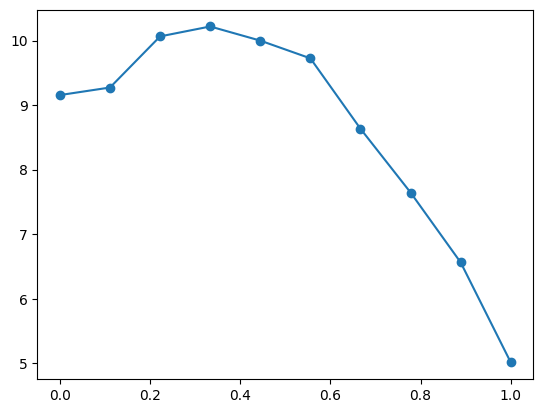

In [4]:
np.random.seed(17)  # for reproducibility

alphas = []
y_bars = []

alphas = np.linspace(0, 1, 10)
y_bars = [measure(alpha) for alpha in alphas]

plt.plot(alphas, y_bars, 'o-');

## Q2

Next you need to create a surrogate model of the response function.

To get you started, I've laid out some boilerplate NumPy in the next cell.

a) Write out the linear surrogate model that needs to be fit (in LaTex or include an image of your handwritten work).

b) Fill in the missing term (the `TODO`).

In [5]:
X = np.vstack( (
    np.ones(shape=(len(y_bars,))),
    alphas,
    alphas**2,
) ).T
X              

array([[1.        , 0.        , 0.        ],
       [1.        , 0.11111111, 0.01234568],
       [1.        , 0.22222222, 0.04938272],
       [1.        , 0.33333333, 0.11111111],
       [1.        , 0.44444444, 0.19753086],
       [1.        , 0.55555556, 0.30864198],
       [1.        , 0.66666667, 0.44444444],
       [1.        , 0.77777778, 0.60493827],
       [1.        , 0.88888889, 0.79012346],
       [1.        , 1.        , 1.        ]])

c) Fit the model using the normal equations. Fill in the `TODO`. What do the beta values represent?

In [6]:
beta = np.linalg.inv(X.T@X)@(X.T@y_bars)
beta

array([  8.97170799,   7.19006478, -11.19284564])

d) Finally, for 100 values of $\alpha$ -- `alphas_what_if` -- generate the values of `y_bar` predicted by your linear surrogate model. Then plot them. We're calling them "what if" values to emphasize the fact that they are estimated by your surrogate and not measured. They say, "If I were to measure `alpha = ...`, I estimate that I would find `y_bar = ...`. Fill in the `TODO`.

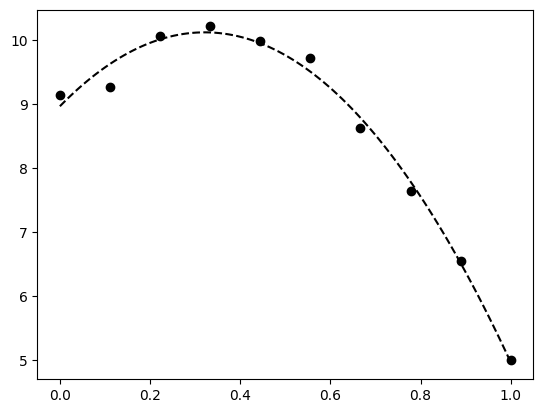

In [7]:
alphas_what_if = np.linspace(0, 1, 100)
y_what_if = beta[0] + beta[1] * alphas_what_if + beta[2] * alphas_what_if**2
plt.plot(alphas, y_bars, 'ok');
plt.plot(alphas_what_if, y_what_if, '--k');

## Q3

a) From your what-if values, estimate the optimal value of $\alpha$. Call it `alpha_opt`.

In [8]:
print("Y maximum:", max(y_what_if))
print("Alpha with Y maximum value:", alphas_what_if[np.argmax(y_what_if)])

Y maximum: 10.126350509551587
Alpha with Y maximum value: 0.32323232323232326


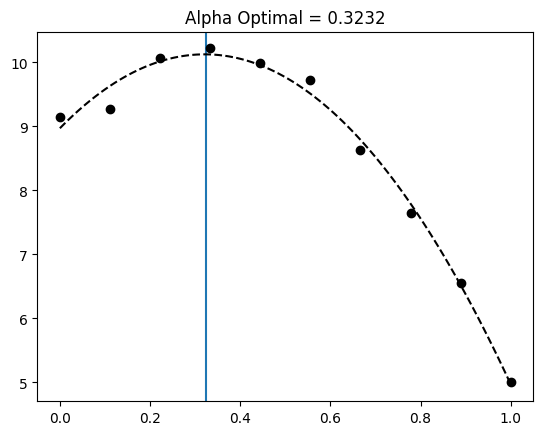

In [9]:
alpha_opt = alphas_what_if[np.argmax(y_what_if)]
plt.axvline(alpha_opt)
plt.title(f"Alpha Optimal = {round(alpha_opt, 4)}")
plt.plot(alphas, y_bars, 'ok');
plt.plot(alphas_what_if, y_what_if, '--k');

Finally, run an A/B test to validate your result.

b) Measure the original production model (which value of $\alpha$ corresponds to the original production model?).

c) Measure the optimal model.

d) Analyze your results. Assume PS = 1.
 
N.B. There is no need to calculate N (the A/B test design) in this exercise. Assume `measure()` is taking care of it.

# A/B test 

### Model A: Score: P(listen)
### Model B: Score: 0.3232xP(listen) + 0.676xP(Like)

b) Measure the original production model (which value of  𝛼  corresponds to the original production model?).

The 𝛼 will be 1 here as the original model contains only probability of listen.

In [10]:
initial_alpha = 1
original_production_model = measure(initial_alpha)
print("Value:", original_production_model)

Value: 5.534251399501329


In [11]:
# C: Measure the optimal model
optimal_model = measure(alpha_opt)
print("Optimal Model:", optimal_model)

Optimal Model: 10.225064641697019


In [12]:
# Analyze the results using statistical test
PS = 1

delta_bar = optimal_model - original_production_model


se_delta_bar = np.sqrt(2*se_y_bar**2)

t = delta_bar / se_delta_bar

# check practical significance and statistical significance
if delta_bar > PS and t > 1.64:
    print(f"t = {t:.3f}, delta_bar = {delta_bar:.3f}: Accept B")
else:
    print(f"t = {t:.3f}, delta_bar = {delta_bar:.3f}: Reject B")

t = 16.585, delta_bar = 4.691: Accept B
